In [1]:
%run utils/image_processing.ipynb

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow import feature_column
from tensorflow.keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import GlobalMaxPooling2D

In [2]:
DATASET_PATH="datasets/"
DATASET_CSV=DATASET_PATH+"styles.csv"

In [3]:
df_images=pd.read_csv(DATASET_CSV, error_bad_lines=False, warn_bad_lines=False, nrows=100)
df_images=df_images.dropna().reset_index(drop=True)
df_images["image_name"]=df_images.apply(lambda row: str(row["id"])+".jpg",axis=1).reset_index(drop=True)
df_images.head(5)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

   year   usage                             productDisplayName image_name  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012  Casual                          Puma Men Grey T-shirt  53759.jpg

In [4]:
image_files=os.listdir(DATASET_PATH+"images/")

print(df_images.shape)
df_images=df_images[df_images["image_name"].isin(image_files)].reset_index(drop=True)
print(df_images.shape)

(98, 11)
(98, 11)


In [5]:
img_width, img_height, channels = load_image(DATASET_PATH,df_images.iloc[0].image_name).shape

base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, channels))
base_model.trainable = False

model = keras.Sequential([
                    base_model,
                    GlobalMaxPooling2D()
                    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


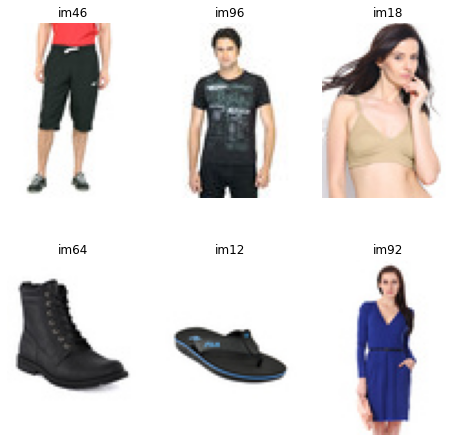

In [6]:
%run utils/image_processing.ipynb
figures = {'im'+str(i): load_image(DATASET_PATH,row.image_name) for i, row in df_images.sample(6).iterrows()}
plot_images(figures, 2, 3)

In [7]:
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(DATASET_PATH,img_name), target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        print("Error in Image File: ", img_name)
        return [0]*2048
        
        

In [8]:
import swifter
error_files=[]
map_embeddings = df_images['image_name'].swifter.apply(lambda img: get_embedding(model, img))
# display(map_embeddings)
df_embs = map_embeddings.apply(pd.Series)

In [9]:
df_images_embd=df_images.join(df_embs)
df_images_embd.head(10)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

   year   usage                             productDisplayName  ...  \
0  2011  Casual               Turtle Check Men Navy Blue Shirt  ...   
1  2012  Casual             Peter England Men Party Blue Jeans  ...   
2  2016  Casual                       Titan Women Silver Watch  ...   
3  2011  Casual  Manchester United Men Solid Black Track Pants  ...   
4  2012  Casual                          Puma Men Grey T-shirt  ...   
5  2011  Casual           Inkfruit Mens Chain Reaction T-shirt  ...   
6  2012  Ethnic               Fabindia Men Striped Green Shirt  ...   
7  2012  Casual                  Jealous 21 Women Purple Shirt  ...   
8  2012  Casual                       Puma Men Pack of 3 Socks  ...   
9  2016  Casual                         Skagen Men Black Watch  ...   

        2038      2039      2040      2041      2042      2043       2044  \
0   0.424309  0.000000  0.000000  5.880396  0.000000  0.000000   6.428891   
1   2.808290  0.000000  3.923500  3.183102  0.000000  0.000000   4.244199   
2   0.218203  7.861292  1.655930  0.000000  0.000000  0.000000   4.702997   
3  22.434395  0.000000  0.000000  0.000000  2.565929  3.330489   0.594360   
4   2.504942  0.000000  1.274122  3.484574  0.786349  0.000000   1.597857   
5   5.022792  0.000000  0.000000  7.353341  1.231075  0.000000   3.193861   
6   0.000000  0.000000  0.000000  2.771447  0.000000  0.000000   1.064348   
7   0.245268  0.000000  0.521103  9.937532  0.000000  0.000000   0.277973   
8   0.000000  0.000000  0.119361  0.420254  2.859296  0.000000  12.139163   
9   0.000000  0.000000  0.678966  0.000000  6.626952  2.881561   0.239893   

        2045      2046      2047  
0   4.408077  0.950040  1.847205  
1   3.268895  2.271736  5.433370  
2   0.000000  2.340580  0.000000  
3   1.130463  3.084230  7.608918  
4   2.515500  0.068348  0.000000  
5   1.409595  6.264234  0.000000  
6  10.387094  0.450423  0.000000  
7   3.074273  0.000000  0.000000  
8   0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  

[10 rows x 2059 columns]

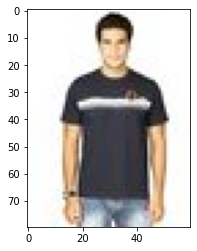

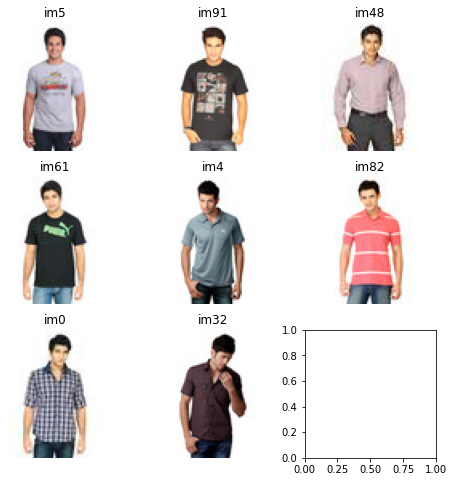

In [10]:
from sklearn.metrics.pairwise import pairwise_distances

cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
indices = pd.Series(range(len(df_images)), index=df_images.index)

def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    return indices.iloc[idx_rec].index, idx_sim

idx_ref = 27
idx_rec, idx_sim = get_recommender(idx_ref, df_images, top_n = 8)

plt.imshow(cv2.cvtColor(load_image(DATASET_PATH,df_images.iloc[idx_ref].image_name), cv2.COLOR_BGR2RGB))
figures = {'im'+str(i): load_image(DATASET_PATH,row.image_name) for i, row in df_images.loc[idx_rec].iterrows()}
plot_images(figures, 3, 3)

In [18]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

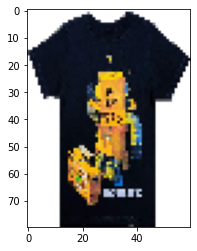

In [28]:

def get_uploaded_image(upload):
    if(len(upload.data)==1):
        nparr = np.frombuffer(upload.data[-1], np.uint8)
        img_np = cv2.imdecode(nparr, flags=1)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        img_np2=cv2.resize(img_np,(img_height, img_width))
    else:
        print("Image NOT UPLOADED! USING DEFAULT IMAGE")
        img_np=cv2.cvtColor(cv2.imread("./test/img1.jpg"), cv2.COLOR_BGR2RGB)
        img_np2=cv2.resize(img_np,(img_height, img_width))
        
    return img_np2


    
plt.imshow(get_uploaded_image(upload))
    

In [35]:
def get_embedding_uploaded(model, img):
    try:
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        print("Error in Image File: ", img_name)
        return [0]*2048
    
    
test_emd=get_embedding_uploaded(model, get_uploaded_image(upload))

array([ 0.       , 35.776443 ,  2.7888958, ...,  0.       ,  0.       ,
        1.9500403], dtype=float32)